In [ ]:
## colab instructions
# !git clone  https://github.com/panoskyr/ddi.git
# %cd ddi
# !pip install torch_geometric
# !pip install ogb

# Imports

In [1]:
import torch 
import numpy 
import matplotlib
import matplotlib.pyplot as plt
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import torch_geometric 
import myutils
import models
import networkx as nx
import random
#from models import SAGE,DotProductLinkPredictor
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import negative_sampling,convert
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dataset_name='ogbl-ddi'
dataset=PygLinkPropPredDataset(name=dataset_name)
data=dataset[0]
adj_t=PygLinkPropPredDataset(name=dataset_name,transform=torch_geometric.transforms.ToSparseTensor('coo'))[0].adj_t.to(device)
#use to_undirected to get some metrics
G=convert.to_networkx(data,to_undirected=True)



cpu


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torch_geometric\utils\sparse.py:176: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ..\aten\src\ATen\SparseCsrTensorImpl.cpp:56.)
  return adj.to_sparse_csr()


In [3]:
initial_embeddings=torch.ones(data.num_nodes, 1).to(device=device)
split_edge=dataset.get_edge_split()

In [3]:
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = models.SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = models.DotProductLinkPredictor().to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
h = model(initial_embeddings, adj_t)

# Randomly sample some training edges and pass them through our basic predictor
torch.manual_seed(1955)
idx = torch.randperm(split_edge['train']['edge'].size(0))[:10]
edges = split_edge['train']['edge'][idx].t()
predictor(h[edges[0]], h[edges[1]])

tensor([0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7310, 0.7311, 0.7311,
        0.7311], grad_fn=<SigmoidBackward0>)

In [4]:
def create_train_batch(all_pos_train_edges,perm,edge_index):
    pos_edges=all_pos_train_edges[perm].t().to(device)

    #produce as many negative edges as positive edges
    neg_edges=negative_sampling(edge_index, num_neg_samples=perm.shape[0], method='dense').to(device)
    training_edges=torch.cat([pos_edges, neg_edges], dim=1)

    pos_labels=torch.ones(pos_edges.shape[1], dtype=torch.float, device=device)
    neg_labels=torch.zeros(neg_edges.shape[1], dtype=torch.float, device=device)

    training_labels=torch.cat([pos_labels, neg_labels], dim=0).to(device)

    return training_edges, training_labels

Example of a training batch of size 64 produces a training batch with size 128--> produces 64 real edges and 64 fake edges (total 64 training examples)
src_edges= [1 X 128]-->64 real and 64 fake edges of source
dest_edges=[1 X 128]--> 64 real and 64 fake destinations

training edges=[src_edges,
                dest_edges]= [ 2 X 
                                [1 X 128]
                                ]

training_labels=[1 X 128] 64 ones and 64 zeroes

In [46]:
batch_size=64
kk,kl=create_train_batch(split_edge['train']['edge'],torch.randperm(n=split_edge['train']['edge'].size(0))[:batch_size],data.edge_index)

# for(src_node,dst_node) in list(zip(kk[0],kk[1])):

#     preds = nx.jaccard_coefficient(G, [(src_node.item(), dst_node.item())])
#     print(list(*preds)[2]) 
kk
d1=spd[kk[0]]
d2=spd[kk[1]]
print(d1.shape,d2.shape)
print(type(d1),type(d2))    

concat_d=torch.add(d1,d2)
print(concat_d.shape)
print(concat_d[0])

torch.Size([128, 200]) torch.Size([128, 200])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([128, 200])
tensor([2., 4., 4., 4., 5., 3., 2., 3., 4., 4., 4., 3., 2., 5., 4., 2., 4., 3.,
        2., 4., 4., 4., 4., 3., 2., 4., 4., 2., 4., 4., 4., 3., 4., 3., 3., 3.,
        2., 3., 4., 2., 3., 3., 3., 4., 4., 4., 4., 4., 3., 3., 4., 2., 2., 4.,
        2., 4., 4., 3., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4., 4., 2., 4., 4.,
        4., 4., 5., 4., 4., 2., 2., 6., 6., 3., 4., 4., 4., 3., 4., 3., 3., 3.,
        4., 4., 4., 4., 4., 4., 2., 4., 4., 4., 2., 3., 4., 3., 4., 4., 4., 4.,
        4., 1., 2., 4., 3., 3., 2., 2., 4., 4., 4., 3., 2., 3., 4., 4., 3., 4.,
        2., 4., 4., 3., 2., 3., 4., 4., 3., 4., 6., 3., 2., 2., 4., 4., 3., 4.,
        3., 4., 2., 6., 4., 6., 4., 4., 4., 4., 3., 3., 4., 3., 4., 4., 4., 4.,
        4., 2., 3., 2., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 2., 3., 3., 2., 4., 4., 4., 4., 4., 6., 4., 6., 4., 4., 4., 4.,
     

In [6]:

preds = nx.jaccard_coefficient(G, [(kk[0][0].item(), kk[0][1].item())])
list(*preds)[2]

0.1391170431211499

In [ ]:
# SAGE AND CONCAT NEURAL LINK PREDICTOR
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = models.SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = models.ConcatNeuralLinkPredictor(hidden_dimension,hidden_dimension,1,4,0.5).to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
h = model(initial_embeddings, adj_t)


# SAGE AND neural LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, initial_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 10)
test(model, predictor, initial_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

In [ ]:
# SAGE AND NEURAL LINK PREDICTOR
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = models.SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = models.NeuralLinkPredictor(hidden_dimension,hidden_dimension,1,4,0.5).to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
h = model(initial_embeddings, adj_t)


# SAGE AND neural LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, initial_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 10)
test(model, predictor, initial_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)


In [ ]:
# SAGE AND DOT LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, initial_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 5)
test(model, predictor, initial_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

# Why our basic SAGE model performs poorly
The node embeddings that are produced do not have any information regarding other measures such as centrality. We will try and enhance our initial embeddings with other metrics before passing them to our SAGE model


In [ ]:
# create embedding with some metrics
# change the function to get training batches to generate additional measures
# for the embeddings

def train_w_metrics(model, predictor, x, adj_t, split_edge, loss_fn, optimizer, batch_size, num_epochs):
  # adj_t isn't used everywhere in PyG yet, so we switch back to edge_index for negative sampling
  # row, col, edge_attr = adj_t.t().coo()
  # edge_index = torch.stack([row, col], dim=0)

  edge_index=PygLinkPropPredDataset(name='ogbl-ddi')[0].edge_index.to(device)
  model.train()
  predictor.train()

  model.reset_parameters()
  predictor.reset_parameters()
  loss_per_epoch = []
  all_pos_train_edges = split_edge['train']['edge']
  for epoch in range(num_epochs):
    epoch_total_loss = 0
    for perm in DataLoader(range(all_pos_train_edges.shape[0]), batch_size,
                           shuffle=True):
      optimizer.zero_grad()

      train_edge, train_label = create_train_batch(all_pos_train_edges, perm, edge_index)
      
      # calculate embeddings and metrics for all the nodes in the training batch
      
      for(src_node,dst_node) in list(zip(train_edge[0],train_edge[1])):

        preds = nx.jaccard_coefficient(G, [(src_node.item(), dst_node.item())])
        score=list(*preds)[2] 
        x[src_node][5]=score 
        x[dst_node][5]=score
        #x[_][5]=nx.resource_allocation_index(G,[(train_edge[0][_],train_edge[1][_])])
        #x[_][6]=nx.adamic_adar_index(G,[(train_edge[0][_],train_edge[1][_])])
        #x[_][7]=nx.preferential_attachment(G,[(train_edge[0][_],train_edge[1][_])])
        


      #pass the augmented embeddings into sage to transform them
      h = model(x, adj_t)

      # Get predictions for our batch and compute the loss
      preds = predictor(h[train_edge[0]], h[train_edge[1]])
      loss = loss_fn(preds, train_label)

      epoch_total_loss += loss.item()

      # Update our parameters
      # pass the loss of the current training batch backwards
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
      optimizer.step()
    loss_per_epoch.append(epoch_total_loss)
    myutils.draw_metric_per_epoch(loss_per_epoch, "Loss per epoch", "Loss", "Epoch", "loss_per_epoch")
    print(f'Epoch {epoch} has loss {round(epoch_total_loss, 4)}')

In [ ]:
#the saved txt are 0-based to be consistent with the node ids in the graph

augmented_embeddings = torch.ones((len(G.nodes)), 5, dtype=torch.float64).to(device)
clustering_coef_dict=myutils.load_data_from_txt("clustering_coef")
betweenness_dict=myutils.load_data_from_txt("betweeness_centrality")
pagerank_dict=myutils.load_data_from_txt("pagerank")
for i in range(G.number_of_nodes()):
    augmented_embeddings[i][0]=clustering_coef_dict[i]
    augmented_embeddings[i][1]=betweenness_dict[i]
    augmented_embeddings[i][2]=pagerank_dict[i]
    augmented_embeddings[i][3]=G.degree[i]
    augmented_embeddings[i][4]=1.0
augmented_embeddings=augmented_embeddings.float()


In [ ]:
# SAGE AND NEURAL LINK PREDICTOR and augmented embeddings
# Initialize our model and LinkPredictor
hidden_dimension = 16
model = models.SAGE(5, hidden_dimension, hidden_dimension, 5, 0.5).to(device)
predictor = models.NeuralLinkPredictor(hidden_dimension,hidden_dimension,1,4,0.5).to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
augmented_init_embeddings=augmented_embeddings
#h = model(augmented_init_embeddings, adj_t)


# SAGE AND neural LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.005)
train(model, predictor, augmented_init_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 100)
test(model, predictor, augmented_init_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

In [9]:
# Sage for embeddings and LinkPredictorEdgeInfo for prediction
# Take the embeddings from the SAGE model and use spatial information from anchor nodes
#before making a prediction
# get the ShortestPathDistance for each node to the anchor nodes
K = 200
sampled_nodes = sorted(random.sample(G.nodes, K))
num_nodes = G.number_of_nodes()
spd = torch.ones(num_nodes, K, dtype=torch.float64).to(device)
for k in range(K):
  distance_from_sample_k_to_all_nodes = nx.shortest_path_length(G, source=sampled_nodes[k])
  for node in distance_from_sample_k_to_all_nodes:
    spd[node][k] = distance_from_sample_k_to_all_nodes[node]
spd = spd.float()
spd

C:\Users\pchrk\AppData\Local\Temp\ipykernel_15216\3606188248.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = sorted(random.sample(G.nodes, K))


tensor([[2., 2., 2.,  ..., 2., 3., 2.],
        [2., 2., 2.,  ..., 2., 3., 1.],
        [3., 3., 3.,  ..., 3., 4., 2.],
        ...,
        [3., 3., 4.,  ..., 4., 4., 4.],
        [2., 2., 3.,  ..., 3., 3., 3.],
        [2., 2., 3.,  ..., 3., 3., 3.]])

In [64]:
def train(model, predictor, x, adj_t, split_edge, loss_fn, optimizer, batch_size, num_epochs,edge_model=False, spd=None):
  # adj_t isn't used everywhere in PyG yet, so we switch back to edge_index for negative sampling
  # row, col, edge_attr = adj_t.t().coo()
  # edge_index = torch.stack([row, col], dim=0)

  edge_index=PygLinkPropPredDataset(name='ogbl-ddi')[0].edge_index.to(device)
  model.train()
  predictor.train()

  model.reset_parameters()
  predictor.reset_parameters()
  loss_per_epoch = []
  all_pos_train_edges = split_edge['train']['edge']
  for epoch in range(num_epochs):
    epoch_total_loss = 0
    for perm in DataLoader(range(all_pos_train_edges.shape[0]), batch_size,
                           shuffle=True):
      optimizer.zero_grad()

      train_edge, train_label = create_train_batch(all_pos_train_edges, perm, edge_index)
      print("train_edge ",train_edge.shape)
      if edge_model:
        h=model(x,edge_index,spd)
      else:
        h = model(x, adj_t)

      d1=spd[train_edge[0]]
      d2=spd[train_edge[1]]
      print("d1 shape ",d1.shape,d2.shape)
      #print(type(d1),type(d2))    

      #add the distance per anchor for each node
      # to combine the features of the two nodes
      edge_distance_info=torch.add(d1,d2)
      # Get predictions for our batch and compute the loss
      preds = predictor(h[train_edge[0]], h[train_edge[1]],edge_distance_info)
      loss = loss_fn(preds, train_label)

      epoch_total_loss += loss.item()

      # Update our parameters
      # pass the loss of the current training batch backwards
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
      optimizer.step()
    loss_per_epoch.append(epoch_total_loss)
    myutils.draw_metric_per_epoch(loss_per_epoch, "Loss per epoch", "Loss", "Epoch", "loss_per_epoch")
    print(f'Epoch {epoch} has loss {round(epoch_total_loss, 4)}')

In [70]:

#turn off gradient tracking for test
@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size, edge_model=False, spd=None):
    model.eval()
    predictor.eval()

    if edge_model:
        edge_index = PygLinkPropPredDataset(name='ogbl-ddi')[0].edge_index.to(device)
        h = model(x, edge_index, spd)
    else:
        h = model(x, adj_t)

    pos_eval_edge = split_edge['edge'].to(device)
    neg_eval_edge = split_edge['edge_neg'].to(device)

    d1=spd[pos_eval_edge[0]]
    d2=spd[pos_eval_edge[1]]
    print("d1 shape ",d1.shape,d2.shape)
      #print(type(d1),type(d2))    

      #add the distance per anchor for each node
      # to combine the features of the two nodes
    edge_distance_info=torch.add(d1,d2)

    pos_eval_preds = []
    for perm in DataLoader(range(pos_eval_edge.shape[0]), batch_size):
        edge = pos_eval_edge[perm].t()
        pos_eval_preds += [predictor(h[edge[0]], h[edge[1]],edge_distance_info).squeeze().cpu()]
    pos_eval_pred = torch.cat(pos_eval_preds, dim=0)

    neg_eval_preds = []
    for perm in DataLoader(range(neg_eval_edge.size(0)), batch_size):
        edge = neg_eval_edge[perm].t()
        neg_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_eval_pred = torch.cat(neg_eval_preds, dim=0)

    total_preds = torch.cat((pos_eval_pred, neg_eval_pred), dim=0)
    labels = torch.cat((torch.ones_like(pos_eval_pred), torch.zeros_like(neg_eval_pred)), dim=0)
    acc = models.BinaryAccuracy(total_preds, labels)

    results = {}
    for K in [10, 20, 30, 40, 50]:
        evaluator.K = K
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_eval_pred,
            'y_pred_neg': neg_eval_pred,
        })[f'hits@{K}']
        results[f'Hits@{K}'] = (valid_hits)
    results['Accuracy'] = acc

    return results
eval = Evaluator(name='ogbl-ddi')
# ogb Evaluators can be invoked to get their expected format
print(eval.expected_input_format) 

==== Expected input format of Evaluator for ogbl-ddi
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges.
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.


In [71]:
# a simple NN with at least 2 fully connected layers
import torch.nn.functional as F
class NeuralLinkPredictorDistanceInfo(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout,spd=None):
        super(NeuralLinkPredictorDistanceInfo, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        distance_dim=32
        self.distance_layer=torch.nn.Linear(200,distance_dim)
        self.matchee_layer=torch.nn.Linear(distance_dim+hidden_channels,hidden_channels)
        self.dropout = dropout
        self.spd=spd

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        self.distance_layer.reset_parameters()



    def forward(self, x_i, x_j,distance_edge_info):
        '''
        x_i: source node embeddings of size [2*batch size, size_of_embedding]
        the size_of_embeddings is the input_channels in the SAGE model is the hidden dimension parameter

        x_j: destination node embeddings of size [2*batch size, size_of_embedding]
        spd: shortest path distance of each node to the anchor nodes of size [num_nodes, K]
        '''
        print("x_i shape: ", x_i.shape, "x_j shape: ", x_j.shape)
        print("distance_edge_info shape: ", distance_edge_info.shape)

        # # Add the distance to the features of the source and destination nodes.
        # x_i = torch.cat([x_i, distance], dim=1)
        # x_j = torch.cat([x_j, distance], dim=1)
        #edge info outputs a 1 X 32 vector for each edge that has distance information
        edge_info=self.distance_layer(distance_edge_info)

        # Propagate the features through the network.
        x = x_i * x_j
        print("x shape before concat: ", x.shape)
        x=torch.concat([x,edge_info],dim=1)
        print("x shape: ", x.shape)
        x=self.matchee_layer(x)
        x=F.relu(x)
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)

        # Output the predictions.
        return torch.sigmoid(x).squeeze()

In [ ]:

# SAGE AND NEURAL LINK PREDICTOR with distance information
# Initialize our model and LinkPredictor
hidden_dimension = 16
model = models.SAGE(1, hidden_dimension, hidden_dimension, 5, 0.5).to(device)
predictor = NeuralLinkPredictorDistanceInfo(hidden_dimension,hidden_dimension,1,4,0.5,spd=spd).to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
#augmented_init_embeddings=augmented_embeddings
#h = model(augmented_init_embeddings, adj_t)


# SAGE AND neural LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.005)
train(model, predictor, initial_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 100,spd=spd)
test(model, predictor, initial_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024,spd=spd)

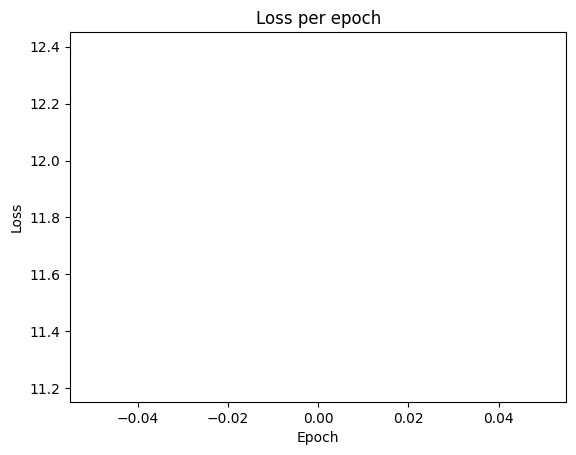

Epoch 0 has loss 11.802


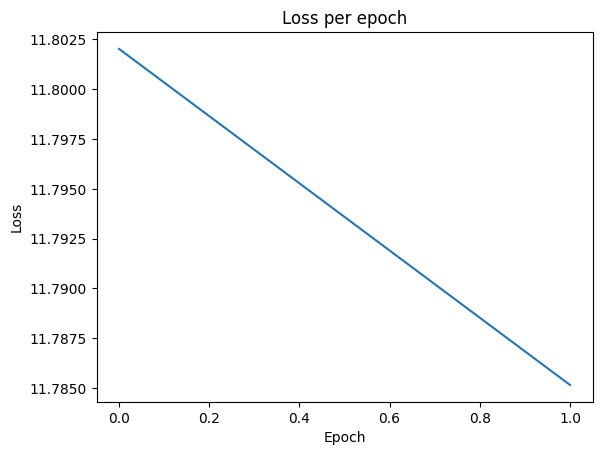

Epoch 1 has loss 11.7852


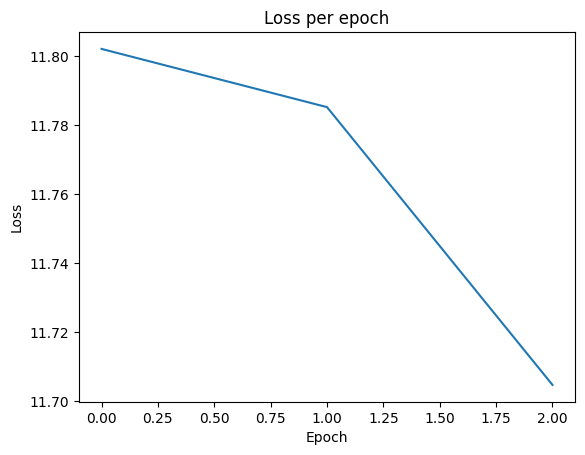

Epoch 2 has loss 11.7048


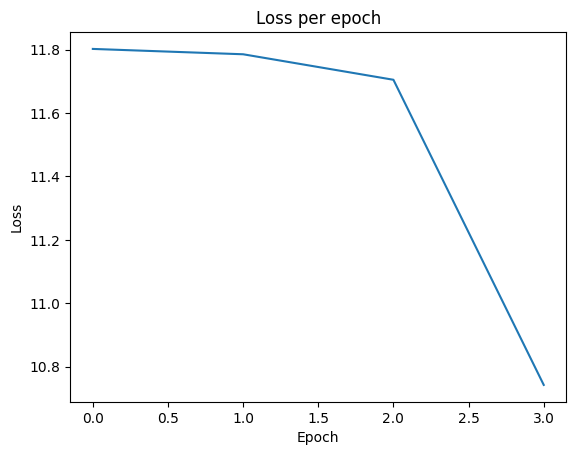

Epoch 3 has loss 10.7428


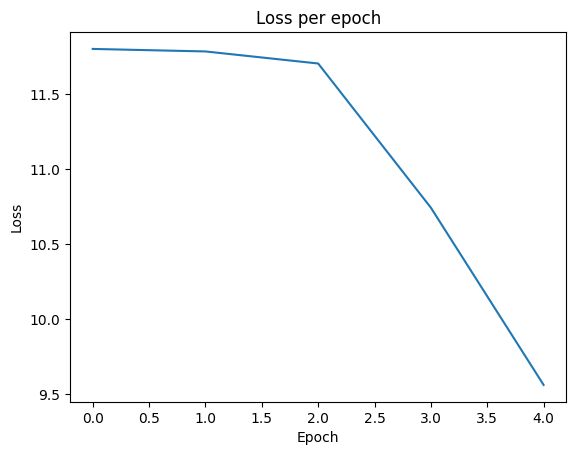

Epoch 4 has loss 9.5605


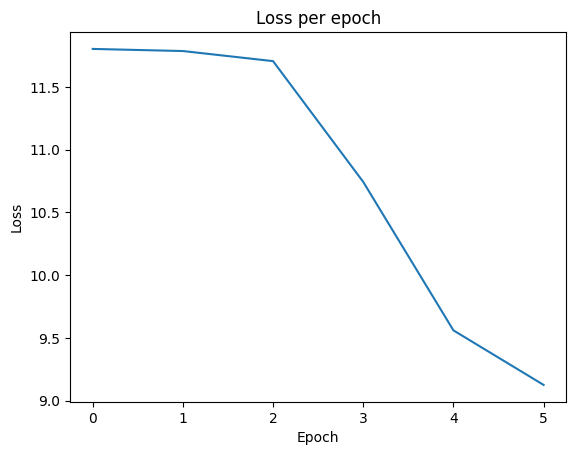

Epoch 5 has loss 9.126


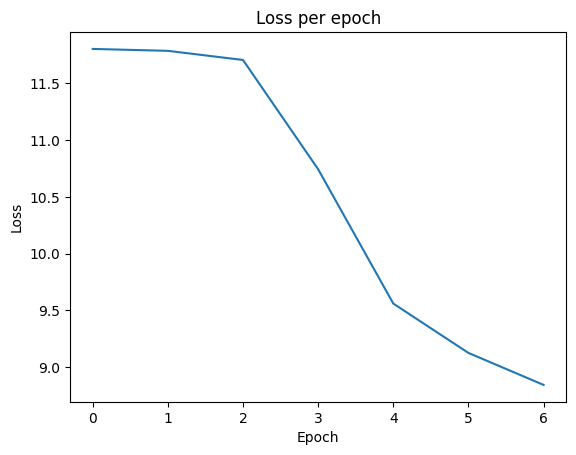

Epoch 6 has loss 8.8444


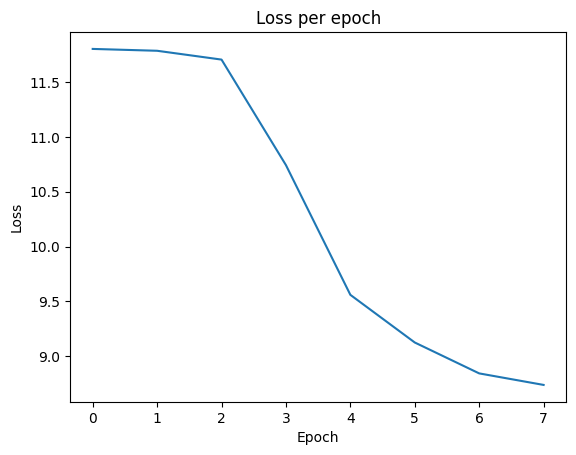

Epoch 7 has loss 8.7394


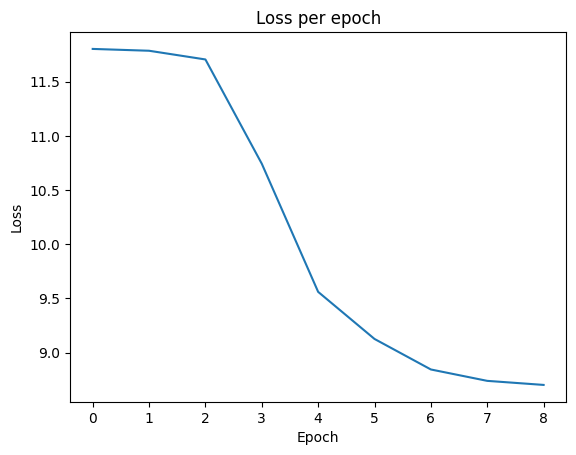

Epoch 8 has loss 8.7019


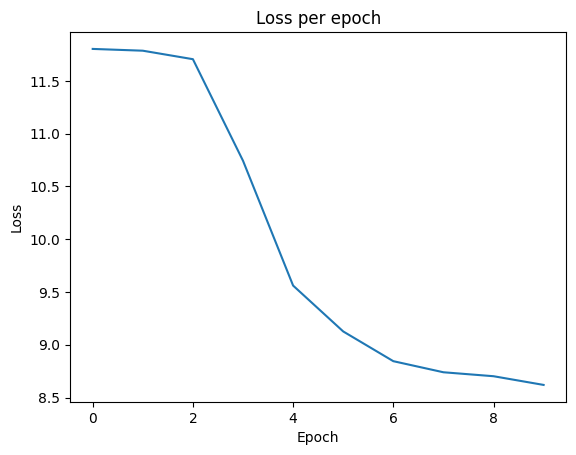

Epoch 9 has loss 8.6195


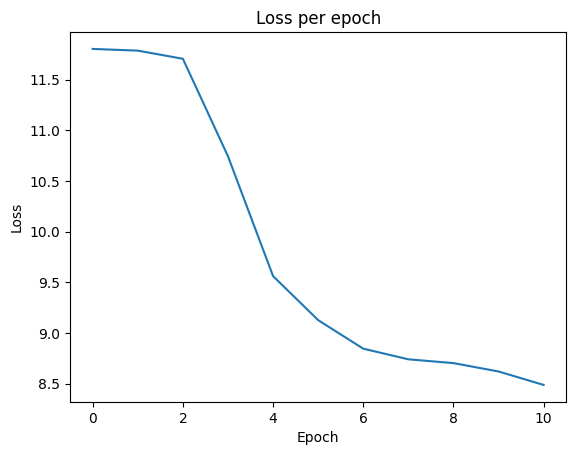

Epoch 10 has loss 8.4867


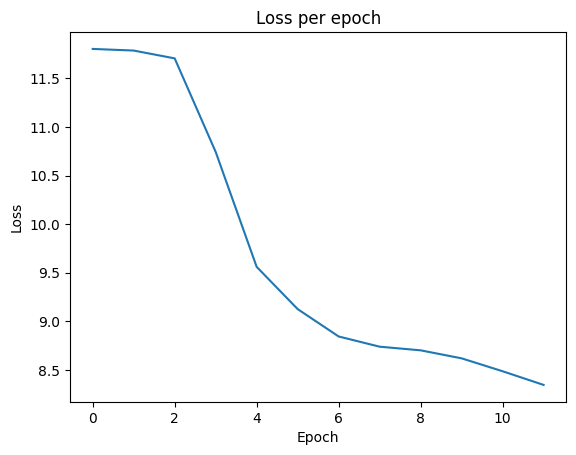

Epoch 11 has loss 8.3461


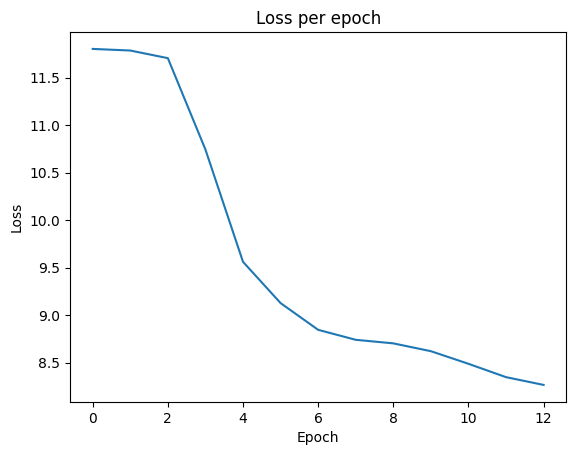

Epoch 12 has loss 8.2644


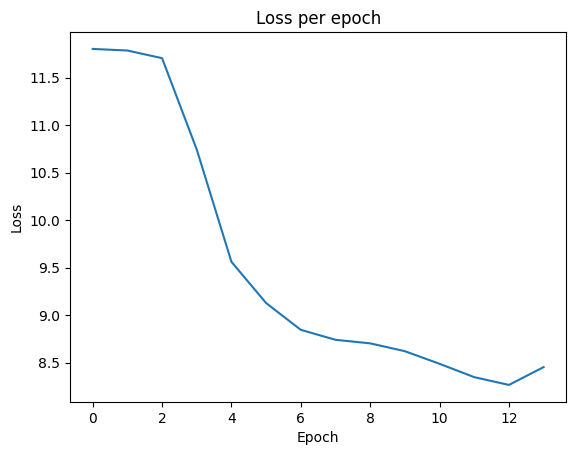

Epoch 13 has loss 8.4518


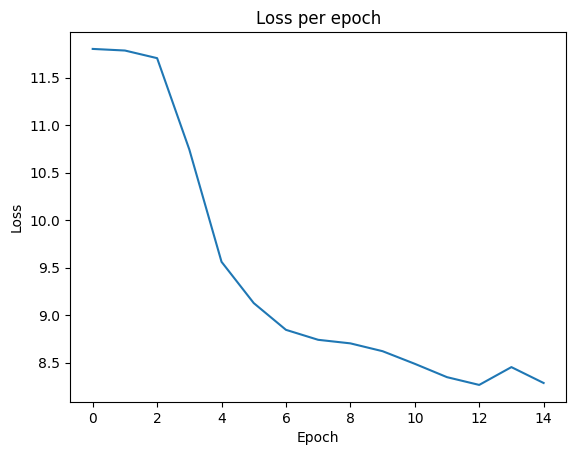

Epoch 14 has loss 8.2847


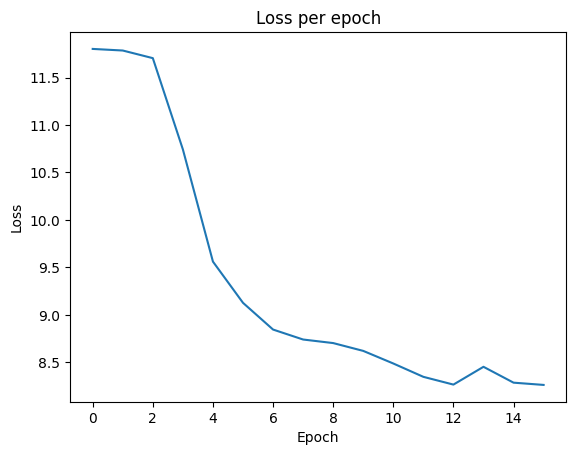

Epoch 15 has loss 8.2609


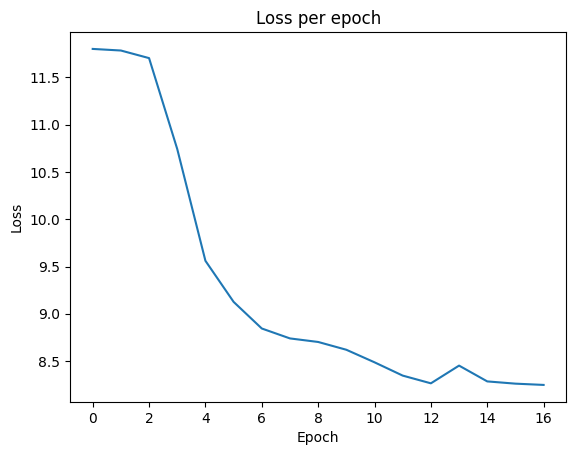

Epoch 16 has loss 8.2475


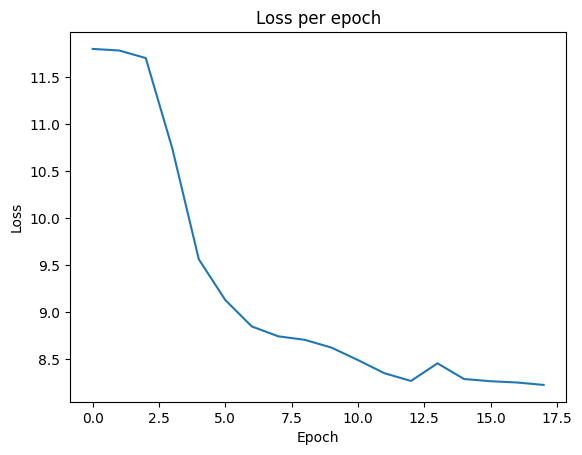

Epoch 17 has loss 8.2217


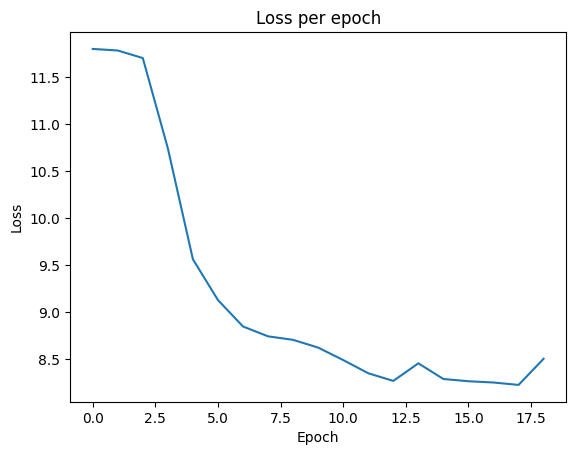

Epoch 18 has loss 8.5004


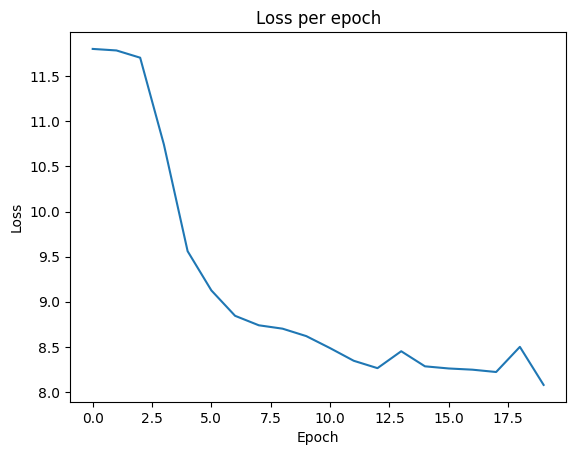

Epoch 19 has loss 8.0786


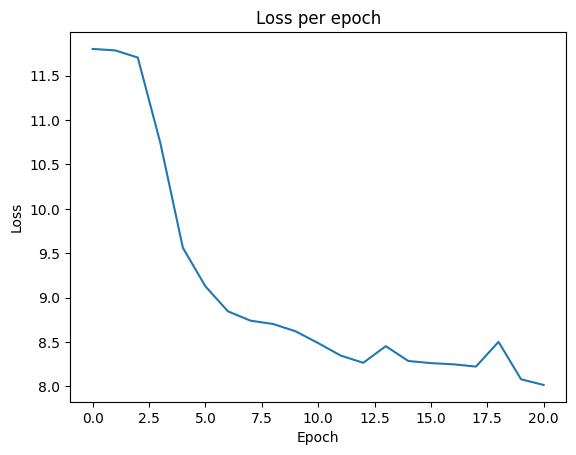

Epoch 20 has loss 8.0152


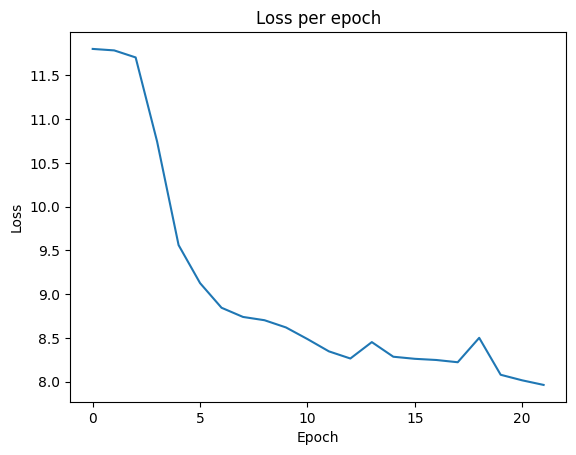

Epoch 21 has loss 7.9625


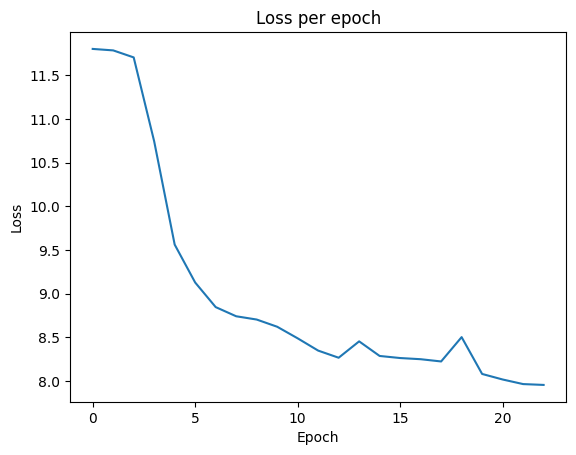

Epoch 22 has loss 7.9529


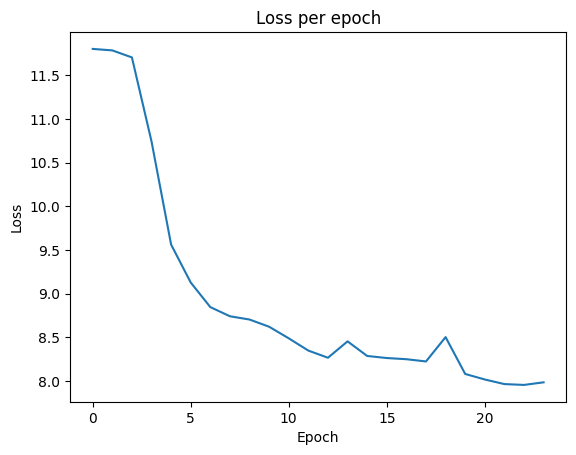

Epoch 23 has loss 7.9827


In [11]:
hidden_dimension = 16
model = models.EdgeSAGE(1, hidden_dimension, hidden_dimension, 5, 0.5).to(device)
predictor = models.NeuralLinkPredictor(hidden_dimension,hidden_dimension,1,4,0.5).to(device)
predictor=models.NeuralLinkPredictor(hidden_dimension,hidden_dimension,1,4,0.5).to(device)
# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
#augmented_init_embeddings=augmented_embeddings
#h = model(augmented_init_embeddings, adj_t)


# SAGE AND neural LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.005)
train(model, predictor, initial_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 100,edge_model=True,spd=spd)
test(model, predictor, initial_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024,edge_model=True,spd=spd)

# Cell for the explicit distance information

In [ ]:
def train(model, predictor, x, adj_t, split_edge, loss_fn, optimizer, batch_size, num_epochs,edge_model=False, spd=None):
  # adj_t isn't used everywhere in PyG yet, so we switch back to edge_index for negative sampling
  # row, col, edge_attr = adj_t.t().coo()
  # edge_index = torch.stack([row, col], dim=0)

  edge_index=PygLinkPropPredDataset(name='ogbl-ddi')[0].edge_index.to(device)
  model.train()
  predictor.train()

  model.reset_parameters()
  predictor.reset_parameters()
  loss_per_epoch = []
  all_pos_train_edges = split_edge['train']['edge']
  for epoch in range(num_epochs):
    epoch_total_loss = 0
    for perm in DataLoader(range(all_pos_train_edges.shape[0]), batch_size,
                           shuffle=True):
      optimizer.zero_grad()

      train_edge, train_label = create_train_batch(all_pos_train_edges, perm, edge_index)
      print("train_edge ",train_edge.shape)
      if edge_model:
        h=model(x,edge_index,spd)
      else:
        h = model(x, adj_t)

      d1=spd[train_edge[0]]
      d2=spd[train_edge[1]]
      print("d1 shape ",d1.shape,d2.shape)
      #print(type(d1),type(d2))    

      #add the distance per anchor for each node
      # to combine the features of the two nodes
      edge_distance_info=torch.add(d1,d2)
      # Get predictions for our batch and compute the loss
      preds = predictor(h[train_edge[0]], h[train_edge[1]],edge_distance_info)
      loss = loss_fn(preds, train_label)

      epoch_total_loss += loss.item()

      # Update our parameters
      # pass the loss of the current training batch backwards
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
      optimizer.step()
    loss_per_epoch.append(epoch_total_loss)
    myutils.draw_metric_per_epoch(loss_per_epoch, "Loss per epoch", "Loss", "Epoch", "loss_per_epoch")
    print(f'Epoch {epoch} has loss {round(epoch_total_loss, 4)}')
    
#turn off gradient tracking for test
@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size, edge_model=False, spd=None):
    model.eval()
    predictor.eval()

    if edge_model:
        edge_index = PygLinkPropPredDataset(name='ogbl-ddi')[0].edge_index.to(device)
        h = model(x, edge_index, spd)
    else:
        h = model(x, adj_t)

    pos_eval_edge = split_edge['edge'].to(device)
    neg_eval_edge = split_edge['edge_neg'].to(device)
    

    pos_eval_preds = []
    for perm in DataLoader(range(pos_eval_edge.shape[0]), batch_size):
        edge = pos_eval_edge[perm].t()

        if spd!=None:
          d1=spd[edge[0]]
          d2=spd[edge[1]]
          edge_distance_info=torch.add(d1,d2)
          pos_eval_preds += [predictor(h[edge[0]], h[edge[1]],edge_distance_info).squeeze().cpu()]
        else:
          pos_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_eval_pred = torch.cat(pos_eval_preds, dim=0)

    neg_eval_preds = []
    for perm in DataLoader(range(neg_eval_edge.size(0)), batch_size):
        edge = neg_eval_edge[perm].t()

        if spd!=None:
          d1=spd[edge[0]]
          d2=spd[edge[1]]
          edge_distance_info=torch.add(d1,d2)
          neg_eval_preds +=  [predictor(h[edge[0]], h[edge[1]],edge_distance_info).squeeze().cpu()]
        else:
          neg_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_eval_pred = torch.cat(neg_eval_preds, dim=0)

    total_preds = torch.cat((pos_eval_pred, neg_eval_pred), dim=0)
    labels = torch.cat((torch.ones_like(pos_eval_pred), torch.zeros_like(neg_eval_pred)), dim=0)
    acc = models.BinaryAccuracy(total_preds, labels)

    results = {}
    for K in [10, 20, 30, 40, 50]:
        evaluator.K = K
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_eval_pred,
            'y_pred_neg': neg_eval_pred,
        })[f'hits@{K}']
        results[f'Hits@{K}'] = (valid_hits)
    results['Accuracy'] = acc

    return results
eval = Evaluator(name='ogbl-ddi')
# ogb Evaluators can be invoked to get their expected format
print(eval.expected_input_format) 
# a simple NN with at least 2 fully connected layers
import torch.nn.functional as F
class NeuralLinkPredictorDistanceInfo(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout,spd=None):
        super(NeuralLinkPredictorDistanceInfo, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        distance_dim=32
        self.distance_layer=torch.nn.Linear(200,distance_dim)
        self.matchee_layer=torch.nn.Linear(distance_dim+hidden_channels,hidden_channels)
        self.dropout = dropout
        self.spd=spd

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        self.distance_layer.reset_parameters()



    def forward(self, x_i, x_j,distance_edge_info):
        '''
        x_i: source node embeddings of size [2*batch size, size_of_embedding]
        the size_of_embeddings is the input_channels in the SAGE model is the hidden dimension parameter

        x_j: destination node embeddings of size [2*batch size, size_of_embedding]
        spd: shortest path distance of each node to the anchor nodes of size [num_nodes, K]
        '''
        print("x_i shape: ", x_i.shape, "x_j shape: ", x_j.shape)
        print("distance_edge_info shape: ", distance_edge_info.shape)

        # # Add the distance to the features of the source and destination nodes.
        # x_i = torch.cat([x_i, distance], dim=1)
        # x_j = torch.cat([x_j, distance], dim=1)
        #edge info outputs a 1 X 32 vector for each edge that has distance information
        edge_info=self.distance_layer(distance_edge_info)

        # Propagate the features through the network.
        x = x_i * x_j
        print("x shape before concat: ", x.shape)
        x=torch.concat([x,edge_info],dim=1)
        print("x shape: ", x.shape)
        x=self.matchee_layer(x)
        x=F.relu(x)
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)

        # Output the predictions.
        return torch.sigmoid(x).squeeze()
    
# SAGE AND NEURAL LINK PREDICTOR with distance information
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = models.SAGE(5, hidden_dimension, hidden_dimension, 5, 0.5).to(device)
predictor = NeuralLinkPredictorDistanceInfo(hidden_dimension,hidden_dimension,1,4,0.5,spd=spd).to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
#augmented_init_embeddings=augmented_embeddings
#h = model(augmented_init_embeddings, adj_t)

initial_embeddings=augmented_embeddings
# SAGE AND neural LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.005)
train(model, predictor, initial_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 100,spd=spd)
test(model, predictor, initial_embeddings, adj_t, split_edge["test"], Evaluator(name='ogbl-ddi'), 64*1024,spd=spd)

# Different Loss Experiment

==== Expected input format of Evaluator for ogbl-ddi
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges.
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.3457, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.3400, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0

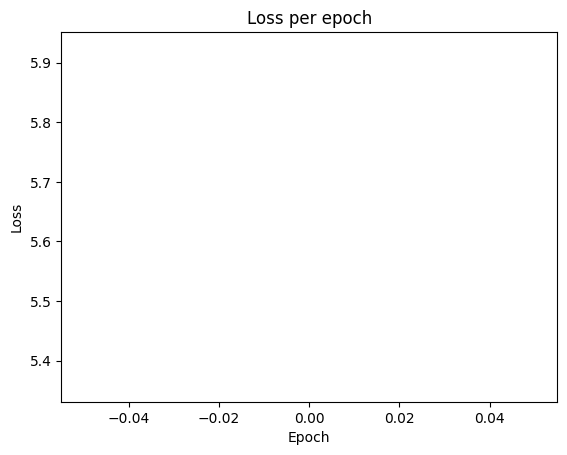

Epoch 0 has loss 5.6411
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.3128, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.3075, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.3104, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.3099, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.3005, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.3051, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
prediction

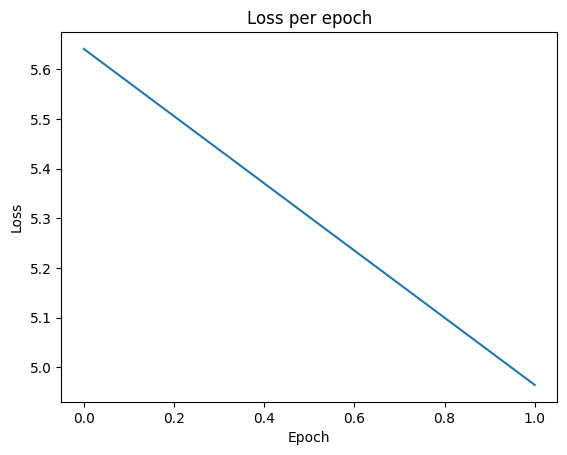

Epoch 1 has loss 4.9648
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.2713, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.2658, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.2611, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.2574, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.2581, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
predictions:  torch.Size([131072]) correct_labels:  torch.Size([131072])
loss:  tensor(0.2547, grad_fn=<NegBackward0>)
train_edge  torch.Size([2, 131072])
prediction

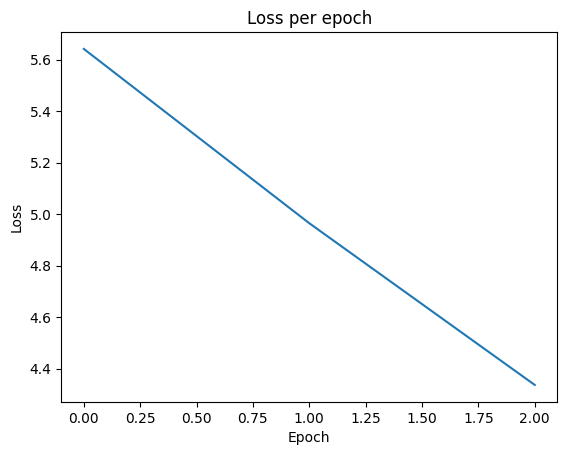

Epoch 2 has loss 4.3374


{'Hits@10': 0.015499404445310101,
 'Hits@20': 0.019387365251069377,
 'Hits@30': 0.02294571088254463,
 'Hits@40': 0.02717826937050993,
 'Hits@50': 0.030601772430687173,
 'Accuracy': 0.7781926989555359}

In [2]:
initial_embeddings=torch.ones(data.num_nodes, 1).to(device=device)
split_edge=dataset.get_edge_split()
def create_train_batch(all_pos_train_edges,perm,edge_index):
    pos_edges=all_pos_train_edges[perm].t().to(device)

    #produce as many negative edges as positive edges
    neg_edges=negative_sampling(edge_index, num_neg_samples=perm.shape[0], method='dense').to(device)
    training_edges=torch.cat([pos_edges, neg_edges], dim=1)

    pos_labels=torch.ones(pos_edges.shape[1], dtype=torch.float, device=device)
    neg_labels=torch.zeros(neg_edges.shape[1], dtype=torch.float, device=device)

    training_labels=torch.cat([pos_labels, neg_labels], dim=0).to(device)

    return training_edges, training_labels
def custom_loss(predictions, correct_labels, pos_weight=0.6):
    print("predictions: ", predictions.shape, "correct_labels: ", correct_labels.shape)
    pos_loss=pos_weight*correct_labels*torch.log(predictions)
    neg_loss=(1-pos_weight)*(1-correct_labels)*torch.log(1-predictions)
    loss = -torch.mean(pos_loss+neg_loss)
    print("loss: ", loss)
    return loss
def train(model, predictor, x, adj_t, split_edge, loss_fn, optimizer, batch_size, num_epochs,edge_model=False, spd=None):
  # adj_t isn't used everywhere in PyG yet, so we switch back to edge_index for negative sampling
  # row, col, edge_attr = adj_t.t().coo()
  # edge_index = torch.stack([row, col], dim=0)

  edge_index=PygLinkPropPredDataset(name='ogbl-ddi')[0].edge_index.to(device)
  model.train()
  predictor.train()

  model.reset_parameters()
  predictor.reset_parameters()
  loss_per_epoch = []
  all_pos_train_edges = split_edge['train']['edge']
  for epoch in range(num_epochs):
    epoch_total_loss = 0
    for perm in DataLoader(range(all_pos_train_edges.shape[0]), batch_size,
                           shuffle=True):
      optimizer.zero_grad()

      train_edge, train_label = create_train_batch(all_pos_train_edges, perm, edge_index)
      print("train_edge ",train_edge.shape)
      if edge_model:
        h=model(x,edge_index,spd)
      else:
        h = model(x, adj_t)

      # d1=spd[train_edge[0]]
      # d2=spd[train_edge[1]]
      # print("d1 shape ",d1.shape,d2.shape)
      #print(type(d1),type(d2))    

      #add the distance per anchor for each node
      # to combine the features of the two nodes
      # edge_distance_info=torch.add(d1,d2)
      # Get predictions for our batch and compute the loss
      preds = predictor(h[train_edge[0]], h[train_edge[1]])
      loss = loss_fn(preds, train_label)

      epoch_total_loss += loss.item()

      # Update our parameters
      # pass the loss of the current training batch backwards
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
      optimizer.step()
    loss_per_epoch.append(epoch_total_loss)
    myutils.draw_metric_per_epoch(loss_per_epoch, "Loss per epoch", "Loss", "Epoch", "loss_per_epoch")
    print(f'Epoch {epoch} has loss {round(epoch_total_loss, 4)}')


#turn off gradient tracking for test
@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size, edge_model=False, spd=None):
    model.eval()
    predictor.eval()

    if edge_model:
        edge_index = PygLinkPropPredDataset(name='ogbl-ddi')[0].edge_index.to(device)
        h = model(x, edge_index, spd)
    else:
        h = model(x, adj_t)

    pos_eval_edge = split_edge['edge'].to(device)
    neg_eval_edge = split_edge['edge_neg'].to(device)

    # d1=spd[pos_eval_edge[0]]
    # d2=spd[pos_eval_edge[1]]
    # print("d1 shape ",d1.shape,d2.shape)
      #print(type(d1),type(d2))    

      #add the distance per anchor for each node
      # to combine the features of the two nodes
    #edge_distance_info=torch.add(d1,d2)

    pos_eval_preds = []
    for perm in DataLoader(range(pos_eval_edge.shape[0]), batch_size):
        edge = pos_eval_edge[perm].t()
        pos_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_eval_pred = torch.cat(pos_eval_preds, dim=0)

    neg_eval_preds = []
    for perm in DataLoader(range(neg_eval_edge.size(0)), batch_size):
        edge = neg_eval_edge[perm].t()
        neg_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_eval_pred = torch.cat(neg_eval_preds, dim=0)

    total_preds = torch.cat((pos_eval_pred, neg_eval_pred), dim=0)
    labels = torch.cat((torch.ones_like(pos_eval_pred), torch.zeros_like(neg_eval_pred)), dim=0)
    acc = models.BinaryAccuracy(total_preds, labels)

    results = {}
    for K in [10, 20, 30, 40, 50]:
        evaluator.K = K
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_eval_pred,
            'y_pred_neg': neg_eval_pred,
        })[f'hits@{K}']
        results[f'Hits@{K}'] = (valid_hits)
    results['Accuracy'] = acc

    return results
eval = Evaluator(name='ogbl-ddi')
# ogb Evaluators can be invoked to get their expected format
print(eval.expected_input_format) 
# SAGE AND NEURAL LINK PREDICTOR
# Initialize our model and LinkPredictor
hidden_dimension = 64
model = models.SAGE(1, hidden_dimension, hidden_dimension, 5, 0.5).to(device)
predictor = models.NeuralLinkPredictor(hidden_dimension,hidden_dimension,1,4,0.5).to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
h = model(initial_embeddings, adj_t)


# SAGE AND neural LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, initial_embeddings, adj_t, split_edge, models.custom_loss, 
      optimizer, 64*1024, 3)
test(model, predictor, initial_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)
